In [1]:
%matplotlib inline
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import cv2

In [2]:
def load_image(path):
    image = cv2.imread(path) #[:,:,::-1]
    return tf.convert_to_tensor(image)

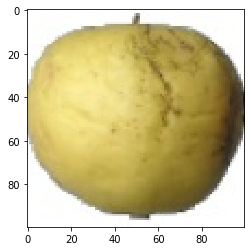

In [3]:
image = load_image("datasets/Fruits360/test/Apple Golden 1/3_100.jpg")
fig = plt.figure()
plt.imshow(cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
model = tf.keras.models.load_model("trained_models/f360_MobileNetV2_04/model.h5")

W1001 18:46:24.521679 4381771200 deprecation.py:323] From /Users/claudiaaranda/anaconda3/envs/IADev/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
image = tf.image.resize(image, [96, 96])
image = tf.expand_dims(image, 0)
prediction = model.predict(image)
print(prediction)

[[0.04815125 0.15222083 0.79962784]]


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


In [7]:
model.layers

In [8]:
mnetLayer = model.layers[0]

In [9]:
mnetLayer.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [19]:
layers_output = [layer.output for layer in mnetLayer.layers]

In [24]:
activationsModel = tf.keras.Model(inputs=mnetLayer.input, outputs=layers_output)

activations = activationsModel.predict(image)

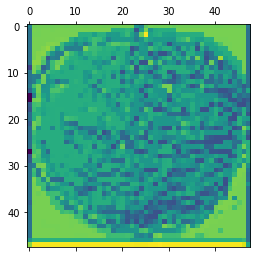

In [45]:
conv1_activation = activations[8]

plt.matshow(conv1_activation[0, :, :, 6], cmap='viridis')

/Users/claudiaaranda/anaconda3/envs/IADev/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

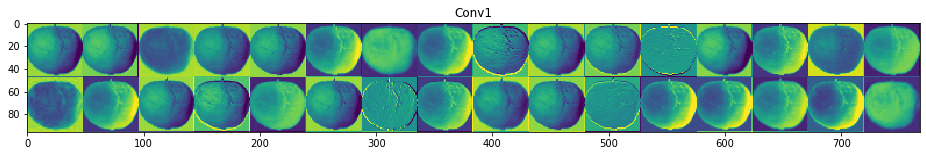

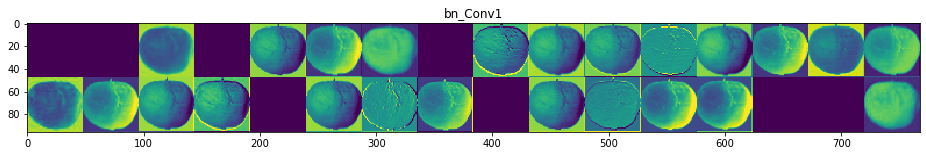

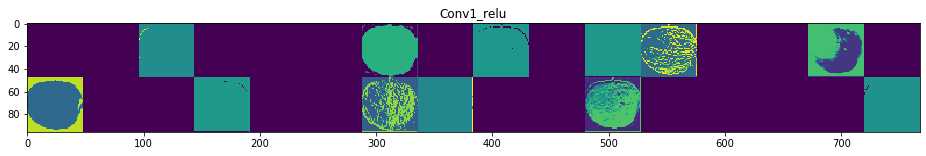

In [50]:
layer_names = []
for layer in mnetLayer.layers[1:5]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations[1:]): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')